# 빅데이터 분석과 활용 중간고사 과제(회귀분석)
#### 컴퓨터학과 2015111461 김수민


- 인스타그램 좋아요 수 예측하기 : 베이킹 관련 게시물에 여러 요인들을 크롤링해서 베이킹 계정의 좋아요를 예측하는 선형 회귀 모델을 만들었습니다. 이를 바탕으로 좋아요수에 영향을 미치는 요인을 파악하여 좋아요 수를 예측하였습니다. 

    0. 개요
    1. 데이터 수집
        1-1. 데이터 크롤링
        1-2. 사용할 데이터셋 가져오기
    2. 데이터 파악 (EDA: 탐색적 데이터 분석)
        2-1. 데이터셋 기본 정보 파악
        2-2. 종속 변수(목표 변수) 탐색
        2-3. 설명 변수 탐색
        2-4. 설명변수와 종속변수 간의 관계 탐색
    3. 좋아요 개수 예측 모델링: 회귀 분석
        3-1. 데이터 전처리
        3-2. 회귀 모델링
        3-3. 모델 해석
        3-4. 모델 예측 결과 및 성능 평가

In [2]:
### 사용할 라이브러리
import pandas as pd ### 데이터 분석을 하기 위한 파이썬 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=DeprecationWarning)

### 1.  데이터 수집

1-1. 데이터 크롤링

!!!! 해당 크롤링은 파이참으로 돌렸습니다. 그래서 경로가 해당 주피터에서는 맞지않습니다. 

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
# import datetime
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from pytz import timezone
from datetime import datetime, timedelta

# 크롤링하기 위한 드라이브 받기
driver_path = '../resources/chromedriver.exe' #크롬드라이버 경로 설정
driver = webdriver.Chrome(driver_path) #드라이버 지정

email = 'bigdatainsta03' #인스타그램 id
pw = 'wowndtnals96!!' #인스타그램 pw

link_list=[] #크롤링한 게시글의 링크를 저장하기 위한 리스트

#인스타그램 검색
def insta_searching(word):
    url = "https://www.instagram.com/explore/tags/"+str(word)
    return url

#첫번째 게시글 선택
def select_first(driver):
    time.sleep(2)  # 2초 기다림
    first_post = driver.find_element_by_css_selector('div._9AhH0') #첫번째 게시글 찾기
    first_post.click() #게시글 클릭

#게시글 크롤링
def get_content(driver):
    html=driver.page_source
    soup = BeautifulSoup(html, 'lxml')

    # [1]현재 게시글 링크 크롤링
    try:
        link=soup.find("a", {"class":"c-Yi7"}).attrs['href']
        link = "https://www.instagram.com" + link
    except:
        link='NULL'

    # [2]현재 게시글 본문 크롤링
    try:
        content=soup.select('div.C4VMK > span')[0].text
    except:
        content = ' '

    # [4]현재 게시글 본문에서의 해시태그 크롤링
    tags = re.findall(r'#[^\s#,\\]+', content)

    # [5]현재 게시글에 좋아요 수 크롤링
    try:
        like=soup.select('a.zV_Nj')[0].text[4:-1]
    except:
        like=0

    # [6]현재게시글을 올린 계정의 id 크롤링
    try:
        upload_id_object = driver.find_element_by_css_selector("div.e1e1d > span.Jv7Aj.MqpiF > a.sqdOP.yWX7d._8A5w5.ZIAjV ")
        upload_id = upload_id_object.text
    except:
        upload_id = None

    # [7]현재 게시글에 댓글부분 크롤링
    try: #대댓글 보기 위한 버튼
        buttons = driver.find_elements_by_css_selector('li > ul > li > div > button')  #대댓글 더 보기 버튼
        for button in range(len(buttons)):
            buttons[button].send_keys(Keys.ENTER)  # 대댓글 버튼 클릭
            replies = driver.find_elements_by_css_selector('ul.TCSYW > div.ZyFrc div.C4VMK > span')  # 대댓글 가져오기
            replies_tags = ''
            replies_tags = re.findall(r'#[^\s#,\\]+', replies[button].text)  # 대댓글 text에 해시태그가 있으면 변수에 저장
            if len(replies_tags) > 1:  # 대댓글에 해시태그가 있는 경우
                tags = replies_tags  # 태그에 저장
    except:
        print("replies fail")

    try: #댓글 데이터 가져오기
        #댓글 쓴 사람의 id
        comment_ids_objects = driver.find_elements_by_css_selector("ul.Mr508 > div.ZyFrc > li.gElp9.rUo9f > div.P9YgZ > div.C7I1f > div.C4VMK > h3")
        #댓글 내용
        comment_texts_objects = driver.find_elements_by_css_selector("ul.Mr508 > div.ZyFrc > li.gElp9.rUo9f > div.P9YgZ > div.C7I1f > div.C4VMK > span")
        for i in range(len(comment_ids_objects)):  # 댓글 쓴 사람 수 대로 탐색
            comment_tags = ''
            comment_tags = re.findall(r'#[^\s#,\\]+', comment_texts_objects[i].text)  # 댓글 text에 해시태그가 있으면 변수에 저장
            if len(comment_tags) > 1:  # 댓글에 해시태그가 있다면
                tags = comment_tags  # 태그에 저장
    except:
        print("comment fail")

    # [4] 현재 게시글 올린 날짜시간 크롤링
    date = soup.select('time._1o9PC.Nzb55')[0]['datetime'][:19] #datetime가져오기
    date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S') #datetime이 문자열로 나와서 datetime형태로 형변환
    date_KST = date+timedelta(hours=+9) #9시간을 더해서 한국시간에 맞춰줌

    dateValue = date_KST.date() #날짜만
    tiemValue = date_KST.time() #시간만
    hourValue = date_KST.hour   #시간(hour)만 저장
    today = datetime.today().date() #크롤링한 날짜

    diff_day = today - dateValue #크롤링한 날짜 - 게시글 업로드 날짜
    diff_day = diff_day.days #며칠 차이가 나는지

    # 링크 리스트 저장
    link_list.append("https://www.instagram.com" + link)

    data = [link, content,diff_day, dateValue, tiemValue,hourValue, like, tags]
    return data

#다음 게시물 선택
def move_next(driver):
    right=driver.find_element_by_css_selector('a.coreSpriteRightPaginationArrow').click()
    time.sleep(3)

#인스타그램 로그인
def insta_login(email, pw):
    driver.get('http://www.instagram.com') #인스타그램 열고
    time.sleep(3)

    input_id = driver.find_elements_by_css_selector('input._2hvTZ.pexuQ.zyHYP')[0] #아이디 입력
    input_id.send_keys(email)
    input_pw=driver.find_elements_by_css_selector('input._2hvTZ.pexuQ.zyHYP')[1] #비밀번호 입력
    input_pw.send_keys(pw)

    input_pw.submit() #로그인하기
    time.sleep(3) #로그인하고 좀 기다리기



#### -------main------- ####


# [1]로그인하기
insta_login(email, pw)

# [2]검색어 입력
word = "베이킹그램"
url = insta_searching(word)
driver.get(url) #검색한 단어 주소 가져오기
time.sleep(4)   #좀 기다리기..

# [3]첫번째 게시글 선택
select_first(driver)

results = [] #게시글 당 크롤링해온 정보 저장할 리스트
target = 1200 #크롤링할 게시글 개수

# [4]크롤링
for i in range(target):
    try:
        data=get_content(driver)
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)

# [5]이미지와 비디오 개수를 세기 위해서 크롤링한 게시글 다시 방문
###  이렇게 두번 반복하는 이유 -> 크롤링함수에서 이 코드를 넣으면 처음만 비디오가 가져와지고 그 다음 게시물부터는 안가져와진다..
### 이렇게 한번 더 돌리니 카운트가 제대로됨..
len_src_img_list=[]
len_src_vid_list=[]

#링크 다시 방문
for i in link_list:
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    driver.get(i)
    tmp_vid = []

    while(1):
        time.sleep(4)
        overlapphoto = driver.find_elements_by_class_name("Yi5aA") #게시물에 사진이나 동영상이 몇개인지 개수

        if (len(overlapphoto)==0): #한개일경우
            if soup.find("video", {"class": 'tWeCl'}): #비디오라면 
                videos = soup.find("video", {"class": 'tWeCl'}).attrs['src']
                tmp_vid.append(videos)  
            break

        else: #여러개일경우
            for n in range(len(overlapphoto)):
                time.sleep(2)
                if soup.find("video", {"class": 'tWeCl'}): #비디오라면
                    videos = soup.find("video", {"class": 'tWeCl'}).attrs['src']
                    if videos not in tmp_vid:
                        tmp_vid.append(videos)
                        print("new_videos", videos)

                try: #다음사진(동영상)으로 넘어가기
                    time.sleep(2)
                    driver.find_element_by_class_name('coreSpriteRightChevron').click()
                    time.sleep(2)
                except NoSuchElementException:
                    break
            break

    len_tmp_img = 0
    # 이미지개수는 전체 개수 - 비디오개수로 저장
    if (len(overlapphoto)==0):
        len_tmp_img = len(overlapphoto) - len(tmp_vid)+1 
        len_src_img_list.append(len_tmp_img)
    else:
        len_tmp_img = len(overlapphoto)-len(tmp_vid)
        len_src_img_list.append(len_tmp_img)
    len_src_vid_list.append(len(tmp_vid))

results_df = pd.DataFrame(results) #데이터프레임생성
results_df.columns=['link', 'content', 'diff_day', 'dateValue', 'timeValue', 'hourValue', 'like', 'tags']
results_df['img_len']=len_src_img_list
results_df['vid_len']=len_src_vid_list

results_df.to_excel('./output/instaBread.xlsx') #엑셀로 저장


[학습데이터셋 구축 과정을 거침]
### !!!**엑셀로 저장한 instaBread.xlsx 파일에서 해시태그를 보고 bread, detail-bread컬럼을 생성하였습니다. 
#### *분석에서 사용하지 않는 link, content, tags컬럼은 삭제하였습니다. 

In [3]:
# 데이터셋 데이터프레임으로 불러오기
df=pd.read_excel("./data/instaBread.xlsx")

In [807]:
#첫번째 5개의 row 살펴보기
df.head()

,diff_day,dateValue,timeValue,hourValue,bread,detail-bread,img_len,vid_len,like
0,40,2021-08-27,16:25:57,16,쿠키,버터쿠키,1,0,136.0
1,18,2021-09-18,12:00:07,12,모닝빵,모닝빵,3,1,5068.0
2,47,2021-08-20,15:58:53,15,스콘,에그스콘,2,1,4044.0
3,9,2021-09-27,09:50:43,9,쿠키,초코쿠키,4,0,442.0
4,44,2021-08-23,10:54:48,10,소금빵,소금빵,4,0,310.0


### 데이터 살펴보기 :Features Descriptions

각 변수의 의미는 다음과 같습니다:

    1. diff_day: 수집한 날짜와 게시글 올라간 날짜의 차이입니다.(ex 수집한 날짜 10월 1일, 게시글 올린 날짜 9월 30일 -> 1일)
    1. dataValue: 게시글을 올린 날짜입니다. 
    2. timeValue: 게시글을 올린 시간입니다.
    3. hourValue: 게시글을 올린 시간(hour)입니다.
    3. bread: 게시글에 해당하는 빵 종류입니다.
    4. detail-bread: 게시글에 해당하는 빵 종류(세부)입니다.
    4. img_len: 게시글에 포함된 사진 개수입니다. 
    5. vid_len: 게시글에 포함된 비디오 개수입니다.
    6. likes: 게시글에 좋아요 개수입니다. 
   

### 2. 데이터 탐색하기 (EDA: Exploratory Data Analysis)
데이터의 각 변수(features, attributes, columns, x들)의 기본 정보 및 각 변수의 특성을 살펴보겠습니다.


In [808]:
### 그래프의 배경 설정 : sns --> seaborn 라이브러리 이용
sns.set_style('darkgrid')

#### 2-1. 데이터 셋의 기본 정보 파악하기

In [809]:
# 1]데이터 셋 구조 보기
df.shape 
# [해석]: 행이 990, 열이 9를 가진 데이터셋입니다. 

(990, 9)

In [810]:
# 2]결측치 탐색 : 비어있는 데이터를 찾습니다. 
df.isnull().sum()
# [해석] bread컬럼, detail-bread, like컬럼에 결측치기 빌견됩니다. 

diff_day          0
dateValue         0
timeValue         0
hourValue         0
bread           119
detail-bread    124
img_len           0
vid_len           0
like             18
dtype: int64

In [811]:
# 3] data type을 확인합니다.
df.info()
# -소수점이 단 한개도 없지만 왜인지 float로 되는 like..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   diff_day      990 non-null    int64         
 1   dateValue     990 non-null    datetime64[ns]
 2   timeValue     990 non-null    object        
 3   hourValue     990 non-null    int64         
 4   bread         871 non-null    object        
 5   detail-bread  866 non-null    object        
 6   img_len       990 non-null    int64         
 7   vid_len       990 non-null    int64         
 8   like          972 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 69.7+ KB


In [4]:
## like를 int 타입으로 바꾸기 위해 like컬럼의 결측치를 제거해줍니다.  [[데이터 전처리]]
df = df.dropna(subset=['like'])
df.isnull().sum()
## [해석] like 컬럼 결측치 지워졌습니다.

diff_day          0
dateValue         0
timeValue         0
hourValue         0
bread           111
detail-bread    115
img_len           0
vid_len           0
like              0
dtype: int64

In [813]:
##like를 float에서 int형식으로 바꿔줍니다 .
df = df.astype({'like': int})
df.info()
## [해석] like 컬럼에 데이터타입이 변경되었습니다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 989
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   diff_day      972 non-null    int64         
 1   dateValue     972 non-null    datetime64[ns]
 2   timeValue     972 non-null    object        
 3   hourValue     972 non-null    int64         
 4   bread         861 non-null    object        
 5   detail-bread  857 non-null    object        
 6   img_len       972 non-null    int64         
 7   vid_len       972 non-null    int64         
 8   like          972 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(3)
memory usage: 72.1+ KB



 ### 컬럼별 데이터 타입 해석


    1. diff_day: 숫자형 변수(연속형 변수)
    1. dataValue: 날짜변수(범주형 변수)
    2. timeValue: 연속형 변수
    3. hourValue: 숫자형 변수(범주형 변수)
    3. bread: 문자형 변수(범주형 변수)
    4. detail-bread: 문자형 변수(범주형 변수)
    4. img_len: 숫자형 변수(이산형 변수) 
    5. vid_len: 숫자형 변수(이산형 변수).
    6. likes: 숫자형 변수(이산형 변수)
   

In [814]:
# 4]슷지형 변수만 뽑아서 기본 통계를 해 봅니다.
df.describe()

,diff_day,hourValue,img_len,vid_len,like
count,972.000000,972.000000,972.000000,972.000000,972.000000
mean,10.976337,15.307613,2.431070,0.088477,169.387860
std,31.421431,5.298604,1.998038,0.298280,780.827083
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,12.000000,1.000000,0.000000,25.000000
50%,6.000000,16.000000,2.000000,0.000000,46.000000
75%,9.000000,19.000000,3.000000,0.000000,108.250000
max,355.000000,23.000000,10.000000,3.000000,19128.000000


In [815]:
# 5]범주형 변수(Categorical Variables)을 알아봅시디
num_bread=df['bread'].unique()
print(len(num_bread))
num_bread

85


array(['쿠키', '모닝빵', '스콘', '소금빵', '케이크', '크림브륄레', '타르트', nan, '머핀', '휘낭시에',
       '연유빵', '도넛', '수플레', '마카롱', '앙금빵', '페스츄리', '피자빵', '크럼블', '까눌레', '잼',
       '롤케이크', '크림빵', '과자', '식빵', '마들렌', '시나몬빵', '갸또쇼콜라', '깜빠뉴', '테린느',
       '구겔호프', '맘모스빵', '팥빵', '브라우니', '갈레트', '소세지빵', '비스코티', '파운드',
       '아몬드트윌', '잠봉뵈르', '붕어빵', '마리토쪼', '팬케이크', '도라야끼', '푸딩', '달고나', '파이',
       '크루아상', '카스텔라', '모카번', '커피콩빵', '쉬폰', '바게트', '튀일', '베이글', '와플',
       '양파빵', '바 ', '다쿠아즈', '티라미수', '치아바타', '랑그드샤', '핫케이크', '슈', '그릭요거트',
       '코펜하겐', '크레페', '초콜렛', '소라빵', '프레즐', '구움과자', '소보로빵', '크러핀', '바브카',
       '제누와즈', '에그슬럿', '진저브레드', '세이글', '치즈빵', '초코빵', '버터링', '요거트', '토스트',
       '감자빵', '포카치아', '떡'], dtype=object)

#### 2-2 종속변수(타겟변수, y)의 탐색

    - like : 좋아요 개수가 타겟변수가 됩니다. 왜냐면, 저는 좋아요의 개수를 맞추기 위함이기 때문입니다. 

In [5]:
# 1] 종속변수의기초 통계량
df['like'].describe()

count      972.000000
mean       169.387860
std        780.827083
min          0.000000
25%         25.000000
50%         46.000000
75%        108.250000
max      19128.000000
Name: like, dtype: float64

<AxesSubplot:ylabel='Frequency'>

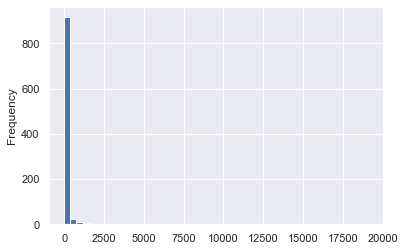

In [817]:
# 2] 종속변수의 분포파악 -시각화를 해서 살펴봅니다.
## 히스토그램입니다. 
df['like'].plot.hist(bins=50)

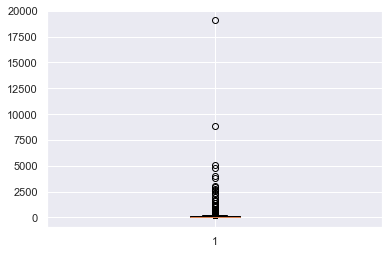

In [818]:
## boxplot 입니다.
plt.boxplot(df['like'])
plt.show()

[해석] 평균과 너무 동떨어진 최대치 2개를 이상치로 판단합니다. 이상치를 제거하고 다시한번 분포를 파악하겠습니다. 

In [6]:
### 이상치 제거 - 가장큰 max개수 2개삭제 [[데이터 전처리]]
df = df[df['like'] != 19128]
df = df[df['like'] != 8803]

In [7]:
df['like'].describe()

count     970.000000
mean      140.942268
std       402.849483
min         0.000000
25%        25.000000
50%        46.000000
75%       108.000000
max      5068.000000
Name: like, dtype: float64

<AxesSubplot:ylabel='Frequency'>

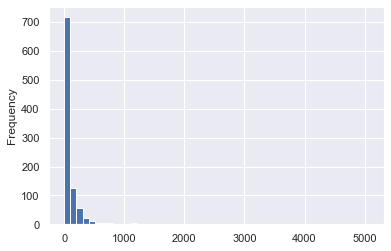

In [820]:
## 히스토그램으로 분포파악
df['like'].plot.hist(bins=50)

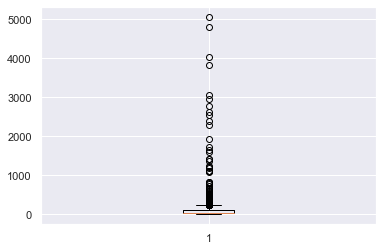

In [821]:
## boxplot으로 분포파악
plt.boxplot(df['like'])
plt.show()

[해석] 보통 좋아요의 개수는 1~300사이에 분포하고 있고 1000개 이하가 대다수이고 1000개 이상인 게시물도 있고, 3000개 이상인 게시글고 몇개 존재한다. 

#### 2-3 설명변수(독립변수, features, attributes, x) 살펴보기
    

<ipython-input-822-5177f6ea2cd6>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df[contents_columns].hist(ax=ax, alpha=0.5)


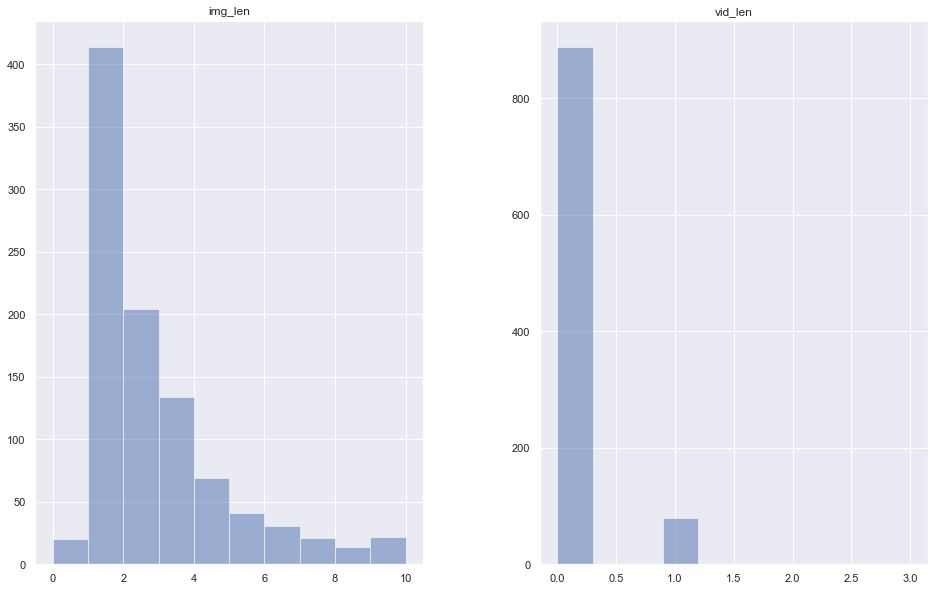

In [822]:
# 1] img_len & vid_len 살펴보기(이미지개수, 비디오개수)
##  히스토그램을 통해 분포도 파악
contents_columns=['img_len', 'vid_len']

fig = plt.figure(figsize = (16, 10))
ax = fig.gca()  # Axes 생성

df[contents_columns].hist(ax=ax, alpha=0.5)
plt.show()

In [823]:
##  이미지 개수 파악
df['img_len'].value_counts()
## [해석] 1개를 가장 많이 올리지만 여러개 올리기도 합니다 1부터 비교적 반비례하게 게시글 개수가 적어집니다.

1     414
2     204
3     134
4      69
5      41
6      31
7      21
0      20
8      14
10     12
9      10
Name: img_len, dtype: int64

In [824]:
##  비디오 개수 파악
df['vid_len'].value_counts()
## [해석] 최대 3개까지 비디오개수가 있지만 대다수가 0개 이고 보통 1개의 비디오를 올립니다. 

0    889
1     79
3      1
2      1
Name: vid_len, dtype: int64

In [825]:
# 2]dateValue & timeValue 살펴보기(데이터업로드 날짜, 데이터업로드 시간)
## 날짜>시간 순으로 정렬
df2 = df.sort_values(['dateValue', 'timeValue']).reset_index().drop(['index'], axis=1)
df2
### [해석] 2020/10/16 ~ 2021/10/6일 총 1년간 게시물이 있다.

,diff_day,dateValue,timeValue,hourValue,bread,detail-bread,img_len,vid_len,like
0,355,2020-10-16,22:11:40,22,쿠키,크랙쿠키,1,0,24
1,355,2020-10-16,22:13:32,22,머핀,초코머핀,1,0,24
2,293,2020-12-17,14:43:00,14,스콘,스콘,1,0,22
3,281,2020-12-29,15:00:17,15,쿠키,치즈쿠키,1,0,20
4,278,2021-01-01,18:58:38,18,머핀,초코머핀,1,0,24
...,...,...,...,...,...,...,...,...,...
965,1,2021-10-05,23:55:48,23,크림브륄레,크림브뤨레,0,1,0
966,0,2021-10-06,00:07:57,0,케이크,샤인머스켓케이크,4,0,21
967,0,2021-10-06,00:28:00,0,스콘,플레인스콘,5,0,4
968,0,2021-10-06,02:08:03,2,쿠키,오렌지쿠키,1,0,2


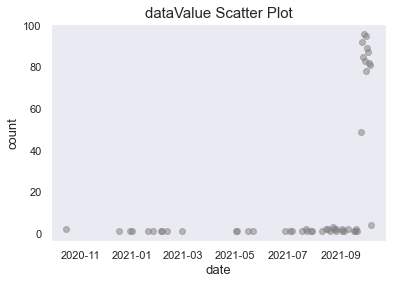

In [826]:
## 날짜의 분포도알아보기
df_dateValue = df["dateValue"].value_counts().reset_index() #dataValue와 value_count를 데이터프레임으로 생성

plt.title("dataValue Scatter Plot", fontsize=15) #제목
plt.scatter(df_dateValue["index"], df_dateValue["dateValue"], color='grey', alpha=.5)
plt.xlabel("date", fontsize=13)
plt.ylabel("count", fontsize=13)
plt.grid()
plt.show()
## [해석]보통 2021/10월에 해당하는 게시물을이 대다수이다. 2020년에 해당하는 게시물을 4개밖에 없다.

In [827]:
## 시간대별 개수를 확인
df_hour = df["hourValue"].value_counts().reset_index()
df_hour

,index,hourValue
0,15,80
1,17,71
2,19,70
3,21,68
4,16,65
5,22,65
6,18,60
7,20,60
8,13,58
9,14,58


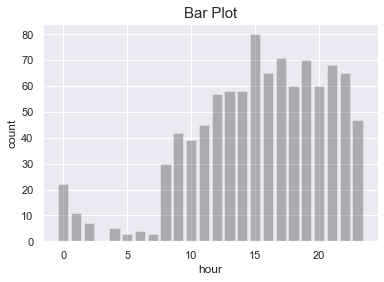

In [828]:
### bar plot으로 시각화해서 살펴보기
plt.title("Bar Plot", fontsize=15)
plt.bar(df_hour["index"], df_hour["hourValue"],color='k', alpha=.3)
plt.ylabel("count", fontsize=12)
plt.xlabel("hour", fontsize=12)
plt.show()

Text(0.5, 0, 'hour')

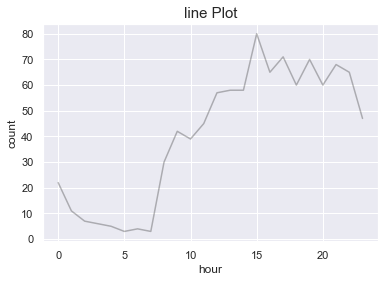

In [829]:
### line Plot으로 시각화해서 살펴보기
df_hour = df_hour.sort_values(['index']) #시간별로 정렬
plt.plot(df_hour["index"], df_hour["hourValue"],color='k', alpha=.3)
plt.title("line Plot", fontsize=15)
plt.ylabel("count", fontsize=12)
plt.xlabel("hour", fontsize=12)
#### [해석] 두가지 시각화 plot을 살펴보았을때 오후 3시에 가장 많은 게시물을 올렸으며 오후3시~8시 사이에 가장 많이 게시글을 올린다. 

In [830]:
# 3]bread 살펴보기(빵 종류)
## 빵 종류확인
num_bread=df['bread'].unique()
print(len(num_bread))
num_bread
## [해석] 89종류의 빵이 있다. 

85


array(['쿠키', '모닝빵', '스콘', '소금빵', '케이크', '크림브륄레', '타르트', nan, '머핀', '휘낭시에',
       '연유빵', '도넛', '수플레', '마카롱', '앙금빵', '페스츄리', '피자빵', '크럼블', '까눌레', '잼',
       '롤케이크', '크림빵', '과자', '식빵', '마들렌', '시나몬빵', '갸또쇼콜라', '깜빠뉴', '테린느',
       '구겔호프', '맘모스빵', '팥빵', '브라우니', '갈레트', '소세지빵', '비스코티', '파운드',
       '아몬드트윌', '잠봉뵈르', '붕어빵', '마리토쪼', '팬케이크', '도라야끼', '푸딩', '달고나', '파이',
       '크루아상', '카스텔라', '모카번', '커피콩빵', '쉬폰', '바게트', '튀일', '베이글', '와플',
       '양파빵', '바 ', '다쿠아즈', '티라미수', '치아바타', '랑그드샤', '핫케이크', '슈', '그릭요거트',
       '코펜하겐', '크레페', '초콜렛', '소라빵', '프레즐', '구움과자', '소보로빵', '크러핀', '바브카',
       '제누와즈', '에그슬럿', '진저브레드', '세이글', '치즈빵', '초코빵', '버터링', '요거트', '토스트',
       '감자빵', '포카치아', '떡'], dtype=object)

In [831]:
## 빵 종류별 개수 확인 
df_bread = df["bread"].value_counts().reset_index()
df_bread.head(40)
## [해석] 쿠키, 케이크가 압도적으로 많고 스콘, 휘낭시에, 마들렌, 파운드, 타르트가 많이 나타난다. 
## 16번째로 많은 도넛밑으로는 총 69개에 해당하는 빵 종류는 10개 미만이다.
## 상위 16개의 빵 종류들이 총 659개로 전체 990개중에서 67%에 해당한다. 

,index,bread
0,쿠키,138
1,케이크,133
2,스콘,56
3,휘낭시에,50
4,마들렌,43
5,파운드,43
6,타르트,41
7,마카롱,32
8,브라우니,23
9,식빵,23


In [832]:
### 최상위 7개 쿠키, 케이크, 스콘, 휘낭시에, 마들렌, 파운드, 타르트 종류에서 세부 종류 파악

#### 쿠키
df_cookie = df[df["bread"]=='쿠키']
df_cookie_detail = df_cookies["detail-bread"].value_counts().reset_index()
print("쿠키 게시글 개수: ", len(df_cookies))
print("세부 쿠키 종류 개수: ", len(df_cookie_detail))
df_detail.head(6)

#### [해석] 여러 메뉴들이 나오지만 총 개수 137개에서 22개는 16프로 해당한다. 

쿠키 게시글 개수:  137
세부 쿠키 종류 개수:  47


,index,detail-bread
0,초코쿠키,22
1,쿠키,15
2,버터쿠키,13
3,르뱅쿠키,11
4,스모어쿠키,11
5,오레오쿠키,4


In [833]:
#### 케이크
df_cake = df[df["bread"]=='케이크']
df_cake_detail = df_cake["detail-bread"].value_counts().reset_index()
print("케이크 게시글 개수: ", len(df_cake))
print("세부 케이크 종류 개수: ", len(df_detail_cake))
df_detail_cake.head(15)

케이크 게시글 개수:  133
세부 케이크 종류 개수:  48


,index,detail-bread
0,바스크치즈케이크,29
1,레터링케이크,11
2,치즈케이크,10
3,초코케이크,9
4,레몬케이크,8
5,케이크,7
6,블루베리케이크,5
7,컵케이크,4
8,당근케이크,3
9,민트초코케이크,3


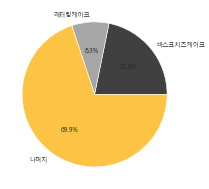

In [834]:
##### 케이크 세부 종류 퍼센트 시각화
plt.rc('font', family='Malgun Gothic') # 그래프에 한글 표시
plt.figure(figsize=(10,6), dpi=40)
size = [29, 11, 93] # 데이터
label = ['바스크치즈케이크', '레터링케이크','나머지'] 
colors = ['#404040',  '#A6A6A6', '#FDC345', ]
plt.pie(size, labels=label, autopct='%.1f%%', colors=colors)
plt.show()

#### [해석]바스크치즈케이크가 전체중 22프로를 차지하기때문에 
#### detal-bread가 바스크치즈케이크면 bread도 케이크에서 바스크치즈케이크로 바꿔준다.

In [835]:
##### 케이크 ->바스크치즈케이크 변경 [[데이터 전처리]]
df = df.reset_index().drop(['index'], axis=1) #index정리
for i in range(len(df)):
    a = df['detail-bread'][i]
    if a == '바스크치즈케이크': #detail-bread가 바스크치즈케이크라면 
        df.at[i,'bread'] = '바스크치즈케이크' #bread를 바스크치즈케이크로 바꿔주기
df.loc[[51]]#변경된거 확인

,diff_day,dateValue,timeValue,hourValue,bread,detail-bread,img_len,vid_len,like
51,1,2021-10-05,17:06:22,17,바스크치즈케이크,바스크치즈케이크,6,0,6


In [836]:
#### 스콘
df_scone = df[df["bread"]=='스콘']
df_detail_scone = df_scone["detail-bread"].value_counts().reset_index()
print("스콘 게시글 개수: ", len(df_scone))
print("세부 스콘 종류 개수: ", len(df_detail_scone))
df_detail_scone.head(6)
#### [해석] 플레인스콘은 그냥 스콘임으로 두드러지게 많이 있는 세부 스콘은 없다. 

스콘 게시글 개수:  56
세부 스콘 종류 개수:  23


,index,detail-bread
0,플레인스콘,8
1,얼그레이스콘,7
2,스콘,6
3,초코스콘,5
4,에그스콘,3
5,콘스콘,3


In [837]:
#### 휘낭시에
df_financier= df[df["bread"]=='휘낭시에']
df_detail_financier = df_financier["detail-bread"].value_counts().reset_index()
print("휘낭시에 게시글 개수: ", len(df_financier))
print("세부 휘낭시에 종류 개수: ", len(df_detail_financier))
df_detail_financier.head(6)
#### [해석] 두드러지게 많이 있는 세부 휘낭시에는 없다. 

휘낭시에 게시글 개수:  50
세부 휘낭시에 종류 개수:  14


,index,detail-bread
0,휘낭시에,27
1,코코넛휘낭시에,3
2,츄러스휘낭시에,2
3,크림치즈휘낭시에,2
4,무화과휘낭시에,2
5,솔티카라멜휘낭시에,2


In [838]:
#### 마들렌
df_madeleine = df[df["bread"]=='마들렌']
df_detail_madeleine = df_ma["detail-bread"].value_counts().reset_index()
print("마들렌 게시글 개수: ", len(df_madeleine))
print("세부 마들렌 종류 개수: ", len(df_detail_madeleine))
df_detail_ma.head(6)
#### [해석] 두드러지게 많이 있는 세부 마들렌은 없다. 

마들렌 게시글 개수:  43
세부 마들렌 종류 개수:  14


,index,detail-bread
0,마들렌,20
1,레몬마들렌,7
2,얼그레이마들렌,2
3,밤마들렌,2
4,쑥마들렌,1
5,크림마들렌,1


#### 2-4. 설명변수(x) 와 종속변수(y) 간의 관계 탐색
- 변수간의 상관관계 파악해 봅니다. 

In [839]:
# 1]Person 상관계수를 통해 상관관계 파악
cols = ['diff_day', 'hourValue', 'img_len', 'vid_len', 'like'] #numerical한 feature들
corr = df[cols].corr(method = 'pearson')
corr

,diff_day,hourValue,img_len,vid_len,like
diff_day,1.000000,0.041906,-0.096386,-0.043251,-0.012498
hourValue,0.041906,1.000000,0.016680,0.030062,-0.000304
img_len,-0.096386,0.016680,1.000000,-0.014611,0.057116
vid_len,-0.043251,0.030062,-0.014611,1.000000,0.398159
like,-0.012498,-0.000304,0.057116,0.398159,1.000000


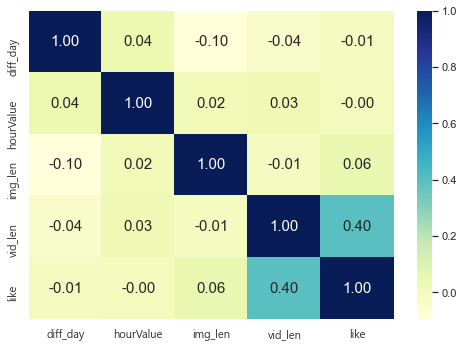

In [840]:
## 상관관계를 heatmap으로 시각화
fig = plt.figure(figsize = (7, 5))
ax = fig.gca()

sns.set(font_scale = 1.0)  # heatmap 안의 font-size 설정 
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15},
                      yticklabels = cols, xticklabels = cols, ax=ax, cmap = "YlGnBu")
plt.tight_layout()
plt.show()

In [841]:
## [해석]
## target variable인 "like"과 다른 변수간의 상관관계를 살펴보면,
## “diff_day - 게시글 올린 날짜와 크롤링한 날짜의 차이”(-0.01) (음의 상관관계)
## “vid_len - 게시글에 포함된 비디오 개수”(0.40) (양의 상관관게)

##### 2.4.1 like(좋아요)~hourValue(시간대)의 관계

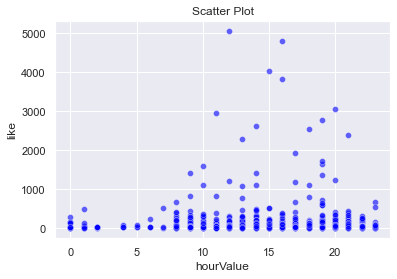

In [845]:
## scatter plot 산점도
sns.scatterplot(data=df, x='hourValue', y='like', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

##### 2.4.2 like(좋아요)~diff_day(날짜차)의 관계

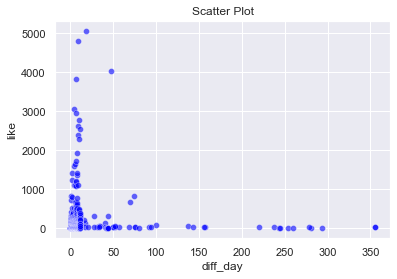

In [844]:
## scatter plot 산점도
sns.scatterplot(data=df, x='diff_day', y='like', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

In [843]:
## 해설) 
## 좋아요 수는 날짜차와의 음의 상관관계를 갖고 있습니다. 
## 즉, 방 갯수가 많은 주택들이 상대적으로 더 높은 가격을 갖고 있습니다.
## 게시글 업로드 짧을 수록 더 좋아요를 많이 받는다고 되어있지만 
## 날짜간 게시글 갯수 편차가 심하여 다시 10월달 이내 게시글만 가지고 상관관계를 분석하였습니다(엑셀상에서)
## 업로드 후 2일까지는 좋아요가 비례하게 올라가지만 그 이후로는 상관관계가 없습니다. 

##### 2.4.3 like(좋아요)~vid_len의 관계

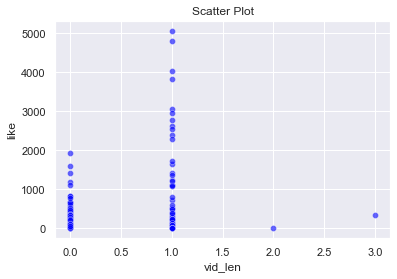

In [846]:
## scatter plot
sns.scatterplot(data=df, x='vid_len', y='like', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

In [773]:
## 해설)
## 좋아요와 비디오개수가 양의 상관관계를 갖고 있습니다. 
## 즉, 비디오개수가 많을 수록 좋아요를 더 많이 받는것을 알 수 있습니다. 

##### 2.4.3 빵별 차이 탐색 

In [774]:
## 각 빵 데이터 갯수 살펴보기 
df['bread'].value_counts()
## 해설) 85 종류의 빵이 있습니다. 

쿠키       138
케이크      104
스콘        56
휘낭시에      50
마들렌       43
        ... 
아몬드트윌      1
맘모스빵       1
시나몬빵       1
앙금빵        1
떡          1
Name: bread, Length: 85, dtype: int64

<AxesSubplot:>

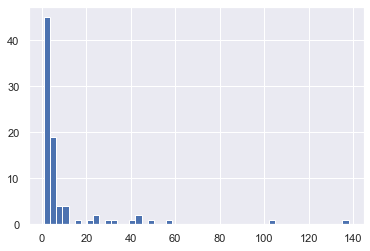

In [775]:
### 각 빵  데이터 갯수 살펴보기 (bar plot)을 활용해서 시각화를 합니다.
df['bread'].value_counts().hist(bins=50)
### [헤석] 10개 이하에 빵종류가 나머지는 60개 이하로 나타난다

In [776]:
plt.rcParams['font.family'] = 'NanumGothic' #한글 표시를 위함

<AxesSubplot:xlabel='like', ylabel='bread'>

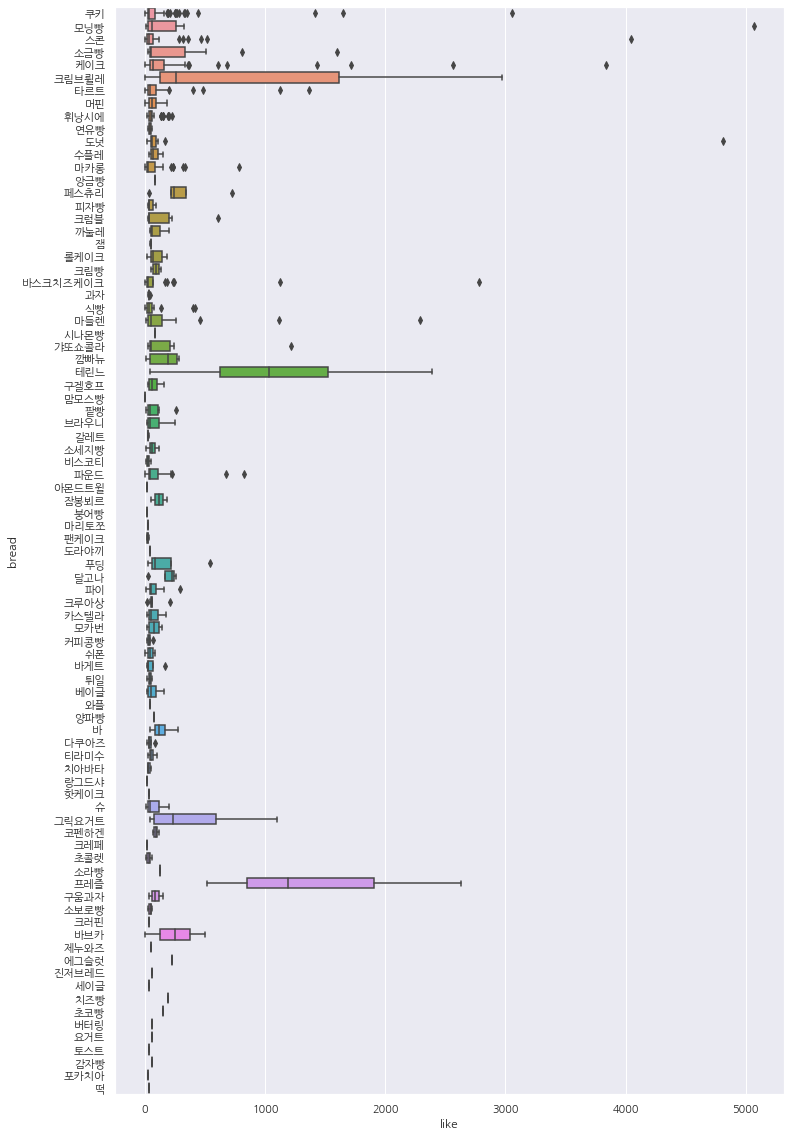

In [777]:
### 빵별 좋아요 특징 (boxplot 이용)
fig = plt.figure(figsize = (12, 20))
sns.boxplot(x='like', y='bread', data=df)

In [778]:
### 해석) bread컬럼에 빵을 태깅하면서 봤던 내용을 가지고 해석을 해보자면, 
### 사람들이 많이 올리는 쿠키, 케이크등은 베이킹 계정이 아니라 일반 사람들도 만들어서 올리는 경우가 많았습니다. 
### 그래서 올린 게시글 수는 많지만 그에 비해 좋아요는 두드러지게 많지는 않습니다.
### 이에 반해 브륄레, 테린느, 프레즐같이 일반인들이 만들기 쉽지 않은 메뉴의 경우에는 이미 좋아요를 항상 많이 받는 베이킹 계정에서 올리는 
### 경향이 많았습니다. 그래서 이러한 boxplot의 모양이 나오지 않았나 생각합니다.

### 3. 좋아요 개수 예측 모델링: 회귀분석
- 이제 변수들을 활용하여 베이킹 게시글에 좋아요 개수를 예측하는 회귀 모델을 만들어 보겠습니다.

#### 3-1 데이터 전처리
- 문자열인 bread를 학습 시키기 위해서 encoding해 전처리 해준다
- encoding 방법은 2가지가 있다. 레이블인코딩, 원핫인코딩
- 레이블 인코딩은 문자형을 숫자형으로 바꿔주는 인코딩 방법이다. 
- 원핫 인코딩은 문자열을 컬럼으로 넣어서 해당 열이 그 값인지, 아닌지 이진으로 나타나는 방법이다. 
- 원핫인코딩을 사용했을시, 85개의 bread종류를 컬럼으로 변경해서 feature값이 너무 많아지는 단점이 있다 
- 레이블 인코딩을 사용했을시, 숫자 크기때문에 선형 회귀 분석에는 맞지않는 담점이 있다. 


1. 전처리 - [1] 인코딩
1. 전처리 - [2] train/test셋으로 나누기
1. 전처리 - [3] 다중공산성 확인

##### 3.1.1 인코딩

In [779]:
# 1. 전처리 - [1] 인코딩
# 두가지 인코딩을 다 해봐서 결과값 확인해보기
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = df.dropna(subset=['bread', 'like']) #결측치 제거
df = df.reset_index() #인덱스 정렬
df_label_enc = df.copy() #레이블인코딩한 데이터프레임을 담기위함
df_oneHot_enc = df.copy() #원핫인코딩한 데이터프레임을 담기위함 


# 레이블인코딩
df1 = pd.DataFrame({'bread': df_label_enc['bread']}) #데이터프레임 생성
df1 = df1.apply(LabelEncoder().fit_transform) #레이블인코딩
df_label_enc = df_label_enc.drop('bread', axis=1) #원래있던 컬럼 삭제
df_label_enc['bread'] = df1['bread'] #인코딩한 컬럼을 원래 컬럼에 붙이기

#레이블인코딩한 데이터프레임 학습데이터셋으로 정리
df_label_enc = df_label_enc.drop(['index', 'dateValue', 'timeValue', 'detail-bread'], axis=1)
df_label_enc = df_label_enc[['diff_day', 'hourValue', 'img_len', 'vid_len', 'bread', 'like']]
df_label_enc = df_label_enc.astype({'like': int})


# 원핫인코딩
df2 = pd.DataFrame({'bread': df_oneHot_enc['bread']}) #데이터프레임 생성
df2 = pd.get_dummies(df2) #원핫인코딩
df2 = df2.reset_index() #인덱스 정렬
df_oneHot_enc = df_oneHot_enc.drop('bread', axis=1) #원래있던 컬럼 삭제
df_oneHot_enc = pd.concat([df_oneHot_enc, df2], axis=1, sort=False) #인코딩한 데이터프레임 원래 프레임과 합치기

#원핫인코딩한 데이터프레임 학습데이터셋으로 정리
df_oneHot_enc = df_oneHot_enc.drop(['index', 'dateValue', 'timeValue', 'detail-bread'], axis=1)
df_oneHot_enc = df_oneHot_enc.astype({'like': int})

In [780]:
df_label_enc.head()
# [해석] bread컬럼이 숫자형으로 바뀜을 볼 수 있다. 

,diff_day,hourValue,img_len,vid_len,bread,like
0,40,16,1,0,62,136
1,18,12,3,1,21,5068
2,47,15,2,1,40,4044
3,9,9,4,0,62,442
4,44,10,4,0,33,310


In [781]:
df_oneHot_enc.head()
# [해석] bread종류대로 컬럼이 늘어남을 볼 수 있다. 

,diff_day,hourValue,img_len,vid_len,like,bread_갈레트,bread_감자빵,bread_갸또쇼콜라,bread_과자,bread_구겔호프,...,bread_파이,bread_팥빵,bread_팬케이크,bread_페스츄리,bread_포카치아,bread_푸딩,bread_프레즐,bread_피자빵,bread_핫케이크,bread_휘낭시에
0,40,16,1,0,136,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18,12,3,1,5068,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,47,15,2,1,4044,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,9,4,0,442,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,10,4,0,310,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 3.1.2 training/test set 나누기

In [782]:
# 1. 전처리 - [2] train/test셋으로 나누기
from sklearn.model_selection import train_test_split

# 레이블인코딩
df_label_enc_for_x = df_label_enc.drop('like', axis=1)
X = df_label_enc_for_x
y = df_label_enc['like']

# 원핫인코딩
# df_oneHot_enc_for_x = df_oneHot_enc.drop('like', axis=1)
# X = df_oneHot_enc_for_x
# y = df_oneHot_enc['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [783]:
X_train.shape, y_train.shape

((687, 5), (687,))

In [784]:
X_test.shape, y_test.shape

((172, 5), (172,))

In [785]:
y_train
### like 값을 의미합니다.

318      23
207      16
61       35
457    3835
670      88
       ... 
715      37
767     151
72       16
235      12
37       66
Name: like, Length: 687, dtype: int32

In [786]:
X_train

,diff_day,hourValue,img_len,vid_len,bread
318,80,18,2,0,20
207,3,16,2,0,22
61,1,12,2,0,62
457,6,16,0,1,60
670,9,21,1,0,18
...,...,...,...,...,...
715,9,13,1,0,84
767,10,18,1,0,60
72,1,10,1,0,60
235,3,9,1,0,40


##### 3.1.3 다중공산성

    - 회귀 분석에서 하나의 feature(예측 변수)가 다른 feature와의 상관 관계가 높으면 (즉, 다중공선성이 존재하면), 회귀 분석 시 부정적인 영향을 미칠 수 있기 때문에, 모델링 하기 전에 먼저 다중공선성의 존재 여부를 확인해야합니다.
    - 보통 다중공선성을 판단할 때 VIF값을 확인합니다. 일반적으로, VIF > 10인 feature들은 다른 변수와의 상관관계가 높아, 다중공선성이 존재하는 것으로 판단합니다. 즉, VIF > 10인 feature들은 설명변수에서 제거하는 것이 좋을 수도 있습니다.

In [787]:
# 1. 전처리 - [3] 다중공산성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['features'] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
v_value = vif.round(1) 

# 10이 넘는 VIF값이 있는지 확인
for i in range(len(v_value)):
  # print( v_value.loc[i])
  if v_value['VIF Factor'][i] >= 10:
    print("10이상:", v_value.loc[i])

In [788]:
# [해설] VIF값을 확인해보면, 모든 변수의 VIF값이 다 10 이하입니다. 따라서 다중공선성 문제가 존재하지 않아 모든 feature을 활용하여 회귀 모델링을 진행하면 됩니다.

### 3-2 회귀모델링
- 먼저 Training set에서 선형 회귀 예측 모델을 학습합니다.
- 그 다음 도출된 모델을 Test set에 적용해 좋아요 개수 (“like”)을 예측합니다. 
- 이 결과는 실제 “like” 값과 비교하여 모델의 예측 성능을 평가하는 데 활용하게 됩니다.


In [789]:
from sklearn import linear_model #선형회귀분석 모델 라이브러리 import

# fit regression model in training set
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train) #모델링

# predict in test set
pred_test = lr.predict(X_test) #예측 모델

### 3-3 모델해석하기
- 각 feature, 설명변수, x, 컬럼에 대한 회귀계수를 확인해 보겠습니다. 

In [790]:
# 1] 계수로 모델 해석하기
## 계수 보여주기
print(lr.coef_)

[ 2.91746846e-01 -4.22723388e+00  2.09041057e+01  6.95288361e+02
 -1.87542468e-01]


In [793]:
## 계수 데이터프레임으로 만들어서 feature랑 같이 보여주기
coefs = pd.DataFrame(zip(df_label_enc_for_x.columns, lr.coef_), columns = ['feature', 'coefficients']) #레이블 인코딩
# coefs = pd.DataFrame(zip(df_oneHot_enc_for_x.columns, lr.coef_), columns = ['feature', 'coefficients']) #원핫 인코딩
coefs

,feature,coefficients
0,diff_day,0.291747
1,hourValue,-4.227234
2,img_len,20.904106
3,vid_len,695.288361
4,bread,-0.187542


In [794]:
## 절대값 크기대로 나열하기
coefs_new = coefs.reindex(coefs.coefficients.abs().sort_values(ascending=False).index)
coefs_new

,feature,coefficients
3,vid_len,695.288361
2,img_len,20.904106
1,hourValue,-4.227234
0,diff_day,0.291747
4,bread,-0.187542


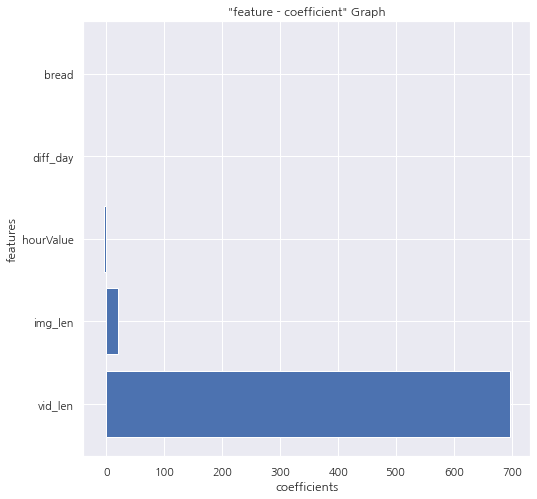

In [795]:
## 시각화로 보여주기

### figure size
plt.figure(figsize = (8, 8))

### bar plot : matplotlib.pyplot 모듈의 barh() 함수를 사용해서 수평 막대 그래프를 그릴 수 있습니다. 
plt.barh(coefs_new['feature'], coefs_new['coefficients'])
plt.title('"feature - coefficient" Graph')
plt.xlabel('coefficients')
plt.ylabel('features')
plt.show()

In [796]:
# 2] 유의성검정 - 통계에서 변수가 유의함을 보여줌
import statsmodels.api as sm

X_train2 = sm.add_constant(X_train)
### 회귀분석모형 수식을 간단하게 만들기 위해 다음과 같이 상수항을 독립변수 데이터에 추가하는 것을 상수항 결합(bias augmentation)작업이라고 합니다.
### ordinary least square 의 약자로, 거리의 최소값을 기준으로 구하는 함수입니다. 

model2 = sm.OLS(y_train, X_train2).fit() # ols모델적용
model2.summary() #모델요약 보여주기

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   like   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     35.86
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           1.26e-32
Time:                        14:45:59   Log-Likelihood:                -5075.5
No. Observations:                 687   AIC:                         1.016e+04
Df Residuals:                     681   BIC:                         1.019e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.1694     57.964      1.883      0.060      -4.640     222.979
diff_day       0.2917      0.459      0.636      0.525      -0.609       1.192
hourValue     -4.2272      2.887     -1.464      0.144      -9.895       1.440
img_len       20.9041      7.945      2.631      0.009       5.305      36.504
vid_len      695.2884     52.417     13.265      0.000     592.370     798.207
bread         -0.1875      0.639     -0.293      0.769      -1.443       1.068
==============================================================================
Omnibus:                      815.144   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83803.971
Skew:                           5.754   Prob(JB):                         0.00
Kurtosis:                      55.870   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [802]:
## [해석]
## p-value : 0.05 보다 작은 피쳐 = img / vid
## R-squre : 0.208 = 독립변수가 종속변수의 20%정도 영향을 끼친다(낮은 수치, 일반적으로 최소 20%로는 넘겨야 유의미하다고 판단)

##### | 해석하기 | 

1. img_len, vid_len만 유의미합니다. (p value < 0.05)
- 레이브인코딩/원핫인코딩 둘다 두피쳐만 유의미하게 나왔습니다.

2. 좋아요 개수에 Positive한 영향을 미칩니다.
- "img_len"(게시글에 올라간 사진 개수),
- "vid_len"(게시글에 올라간 비디오 개수),
: 다른 변수의 값이 고정했을 때, 해당 변수의 값이 클수록 주택의 가격이 높을 것입니다.

### 3-4 모델 예측 결과 및 성능 평가
- 예측 결과를 가시화 합니다  

학습한 모델을 Test set에 적용하여 y값(“like”)을 예측합니다.

예측 결과를 확인하기 위해 실제값과 예측값을 한 plot에 출력해 시각화해보겠습니다.

In [797]:
# 1] 예측 결과 시각화 (test set)

## 데이터프레임으로 결과 나타내기
df = pd.DataFrame({'actual': y_test, 'prediction': pred_test})
df = df.sort_values(by='actual').reset_index(drop=True)
df.head()

,actual,prediction
0,0,709.458223
1,3,45.755174
2,4,159.084389
3,5,83.172275
4,6,158.146677


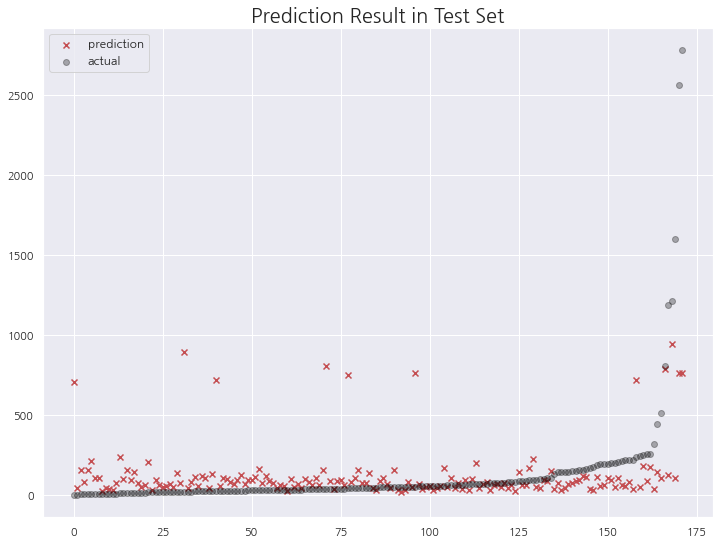

In [798]:
## 시각화해서 보여주기
plt.figure(figsize=(12, 9))
plt.scatter(df.index, df['prediction'], marker='x', color='r')
plt.scatter(df.index, df['actual'], alpha=0.3, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['prediction', 'actual'], fontsize=12)
plt.show()

In [803]:
# [해석] 잘나온 모델은 아니다
# 독립변수가 이미지개수, 비디오개수와 같은 연속형 피쳐들이 존재해야되는데, 시간(hour)는 연속형이 아니였고, 
# 날짜 차이는 개수가 많이 다르기때문에 의미있는 결과값을 얻기 힘들었다.  

- 모델 성능 평가 (R squre 와 RMSE)

In [799]:
# 1] 예측 결과 시각화 (test set)
## R square
print(model.score(X_train, y_train))  # training set
print(model.score(X_test, y_test))  # test set

0.2084189819185348
0.195636175080525


In [ ]:
## [해석] 테스트셋의 r-square값은 19가 나왔다. 최소 20%는 넘겨야 의미있는 결과를 인사이트할 수 있을텐데 좋은 모델은 아니다.

In [800]:
## RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# training set
pred_train = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, pred_train)))

# test set
print(sqrt(mean_squared_error(y_test, pred_test)))

391.0843001528609
301.39889897316306


In [847]:
## [해석] RMSE가 301입니다.. 오차값이 굉장히 크다. 
## R square와 RMSE값을 보았을때 중간고사에서 제가 한 모델은 회귀분석모델로 적합하지 않았습니다. 
## 그 이유를 생각해보았을때 모델의 문제가 아닌, 학습데이터셋의 문제라고 생각이 들었습니다. 
## 다음 회귀분석을 할때에는 종속변수와 독립변수 설정을 회귀분석에 맞게 설정하여서 진행하도록 하겠습니다. 감사합니다. 